In [84]:
from PIL import Image
im = Image.open('30-20_marked.tiff')
im.save('maze.jpeg')

In [18]:
import aspose.words as aw
#prendiamo il file tiff generato dal json e lo mettiamo in formato jpeg
doc = aw.Document()
builder = aw.DocumentBuilder(doc)

shape = builder.insert_image("./prova.tiff")
shape.image_data.save("./prova.jpeg")



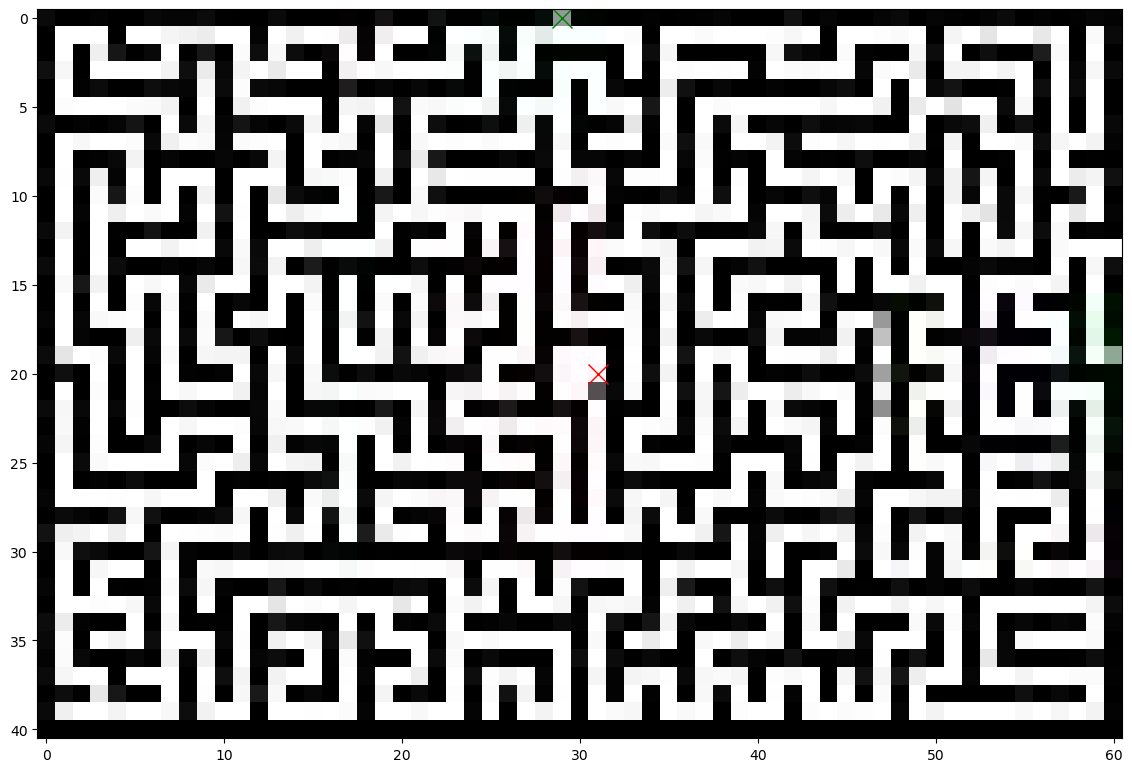

In [85]:
import numpy as np
import matplotlib.pylab as plt
from skimage.morphology import skeletonize
#leggo e ristampo l'immagine
img_name = 'maze.jpeg'
rgb_img = plt.imread(img_name)

plt.figure(figsize=(14,14))
plt.imshow(rgb_img)

#segno con delle x il punto di partenza e di arrivo
x0,y0 = 29, 0
x1,y1 = 31, 20

plt.plot(x0,y0, 'gx', markersize = 14)
plt.plot(x1,y1, 'rx', markersize = 14)


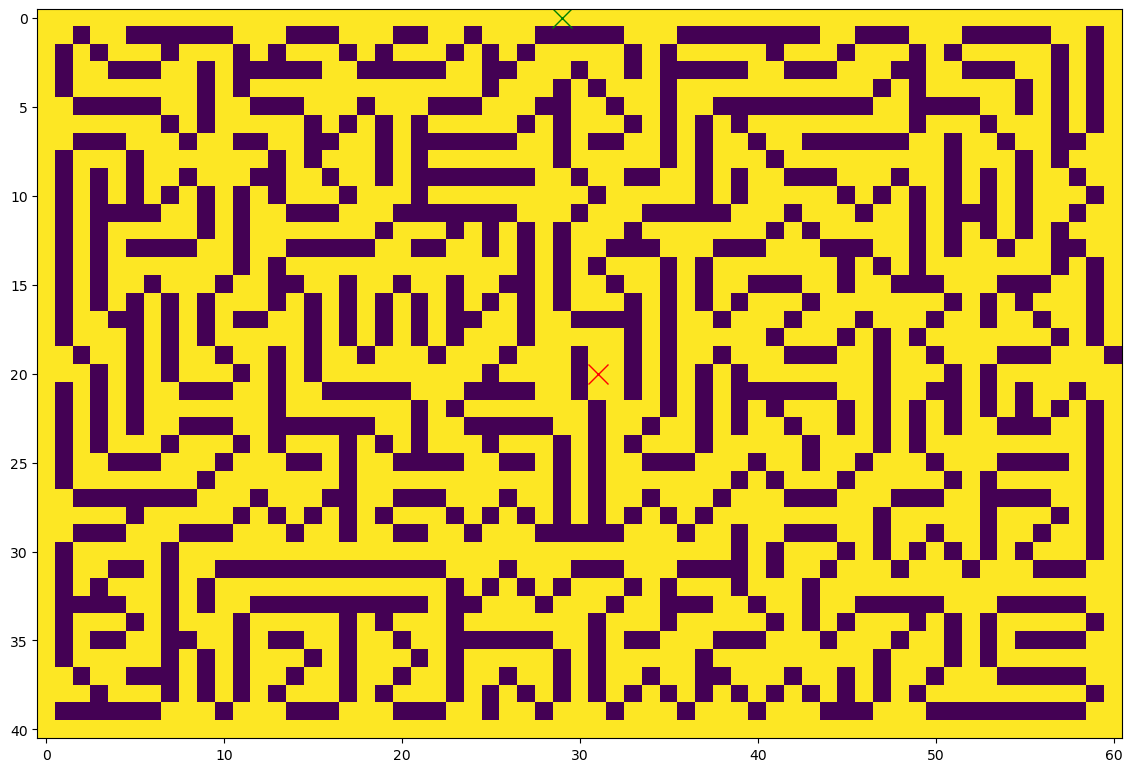

In [87]:
thr_img = rgb_img[:,:,0] > 128
skeleton = skeletonize(thr_img)
plt.figure(figsize=(14,14))
plt.imshow(skeleton)
#map of routes
mapT = ~skeleton
plt.imshow(mapT)
plt.plot(x0,y0, 'gx', markersize=14)
plt.plot(x1,y1, 'rx', markersize=14)
#plt.plot(x,y, 'ro')

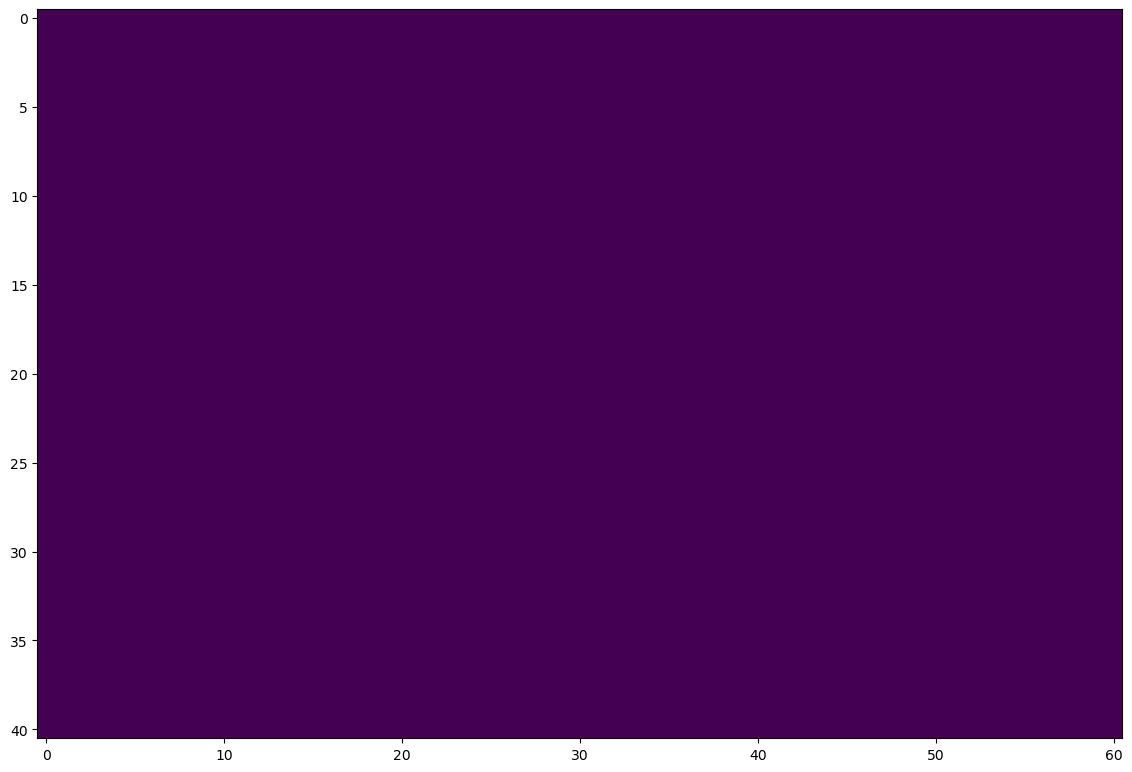

In [89]:
#let'go a temporanery copy of this
_mapt = np.copy(mapT)

#searching to our endpoint and connect to the path
boxr = 60

cpys, cpxs = np.where(_mapt[y1-boxr:y1+boxr, x1-boxr:x1+boxr]==0)

#calibrate points to main scale
cpys += y1-boxr
cpxs += x1-boxr

#find clooset point of possible path endpoints
idx = np.argmin(np.sqrt((cpys-y1)**2 + (cpxs-x1)**2))
y, x = cpys[idx], cpxs[idx]

pts_x = [x]
pts_y = [y]
pts_c = [0]

#mesh of displacements
xmesh, ymesh = np.meshgrid(np.arange(-1,2),np.arange(-1,2))
ymesh = ymesh.reshape(-1)
xmesh = xmesh.reshape(-1)

dst = np.zeros(thr_img.shape)

#Breath first algorithm exploring a tree
while(True):
    #update distance
    idc = np.argmin(pts_c)
    ct = pts_c.pop(idc)
    x = pts_x.pop(idc)
    y = pts_y.pop(idc)
    #Search 3x3 neighbourhood for possible
    ys, xs = np.where(_mapt[y-1:y+2,x-1:x+2] == 0)
    #Invalidate these point from future searchers
    _mapt[ys+y-1, xs+x-1] = ct
    _mapt[y,x] = 999999
    #Set the distance in the distance image
    dst[ys+y-1,xs+x-1] = ct + 1
    #
    pts_x.extend(xs+x-1)
    pts_y.extend(ys+y-1)
    pts_c.extend([ct+1]*xs.shape[0])
    #If we run of points
    if pts_x == []:
        break;
    if np.sqrt((x-x0)**2 +(y-y0)**2) < boxr:
        edx = x
        edy = y
        break;
plt.figure(figsize=(14,14))
plt.imshow(dst)

path_x = []
path_y = []

y = edy
x = edx
while(True):
    nbh = dst[y-1:y+2,x-1:x+2]
    nbh[1,1] = 9999999
    nbh[nbh==0] = 9999999
    #if we reach a deadend
    if np.min(nbh) == 9999999:
        break;
    idx = np.argmin(nbh)
    #find direction
    y += ymesh[idx]
    x += xmesh[idx]

    if np.sqrt((x-x1)**2 + (y-y1)**2) < boxr:
        print('Optimum route found.')
        break
    path_y.append(y)
    path_x.append(x)

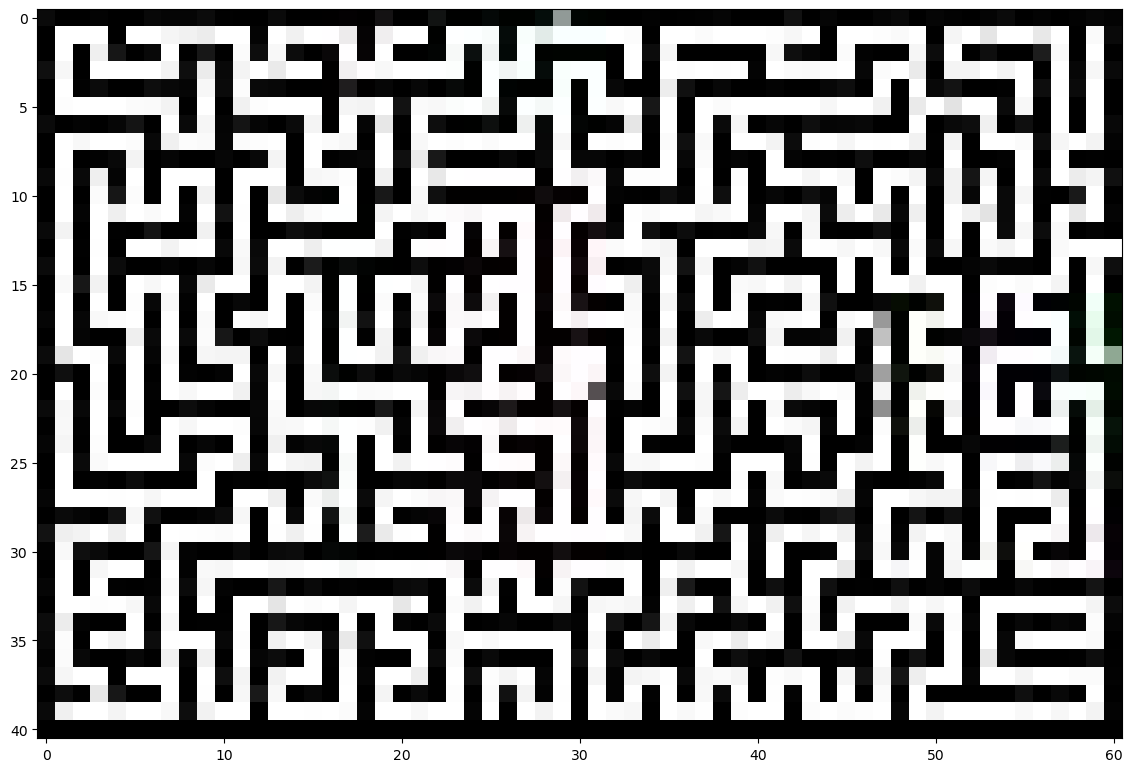

In [90]:
plt.figure(figsize=(14,14))
plt.imshow(rgb_img)
plt.plot(path_x, path_y, 'r-', linewidth=10)

In [66]:
#if rgb_image.shape.__len__() > 2:
#    thr_image = rgb_image[:,:,0] > np.max(rgb_image[:,:,0])/2
#else:
#    thr_image = rgb_image > np.max(rgb_image)/2
#skeleton = skeletonize(thr_image)
#plt.figure(figsize=(8,8))
#plt.imshow(skeleton)